# Machine Learning and Statistics Project 2020

## Introduction 

In this project contains a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to
produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set.
The web service that will respond with predicted power values based on speed values sent as HTTP requests. 
This project contains the following 
1. Jupyter notebook that trains a model using the data set. Description of the model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model,.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README

In [7]:
# import liberires used in project 
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, accuracy_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt 
from tensorflow.keras.layers.experimental import preprocessing


### The Dataset

This study we try to clustering power production using  Kmeans and tensorflow

Attribute Information:

speed km/s
power KW/S


In [4]:
df = pd.read_csv("powerproductionDataSet.csv")


for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:speed == 0
The number of null values in:power == 0


In [36]:
df.shape

(500, 2)

This means that our dataset has 500 rows and 2 columns. Look at what the  dataset actually looks like. To do this, use the head() method:

In [37]:
df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


 ### Statistical details of the dataset

In [71]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


### Test if any missing data in the dataset

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [40]:
df.isnull().values.any()

False

#### Let’s have a look at our data through a scatter plot.

<AxesSubplot:xlabel='speed', ylabel='power'>

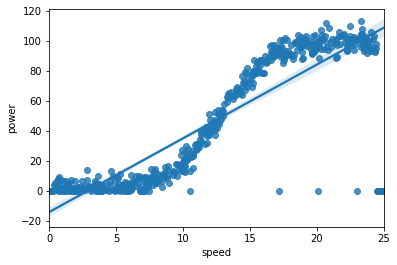

In [22]:
sns.regplot(x="speed", y="power",  data=df)

In [73]:
np.polyfit(df['speed'],df['power'],1)

array([  4.91759567, -13.89990263])

In [74]:
# Calculate mean x and mean y.
x_avg = np.mean(df['speed'])
y_avg = np.mean(df['power'])

# Subtract means from x and y.
x_zero = df['speed'] - x_avg
y_zero = df['power'] - y_avg

# Dot product of mean-adjusted x and y divided by dot product of mean adjusted x with itself.
m = np.sum(x_zero * y_zero) / np.sum(x_zero * x_zero)
# Subtract m times average x from average y.
c = y_avg - m * x_avg

# Let's have a look - same values as above.
m, c

(4.917595665404668, -13.899902630519605)

$$y=4.9x -13.89$$

In [44]:
correlations = df.corr()

In [45]:
correlations

,speed,power
speed,1.000000,0.853778
power,0.853778,1.000000


<AxesSubplot:ylabel='speed'>

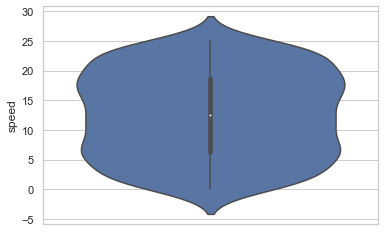

In [33]:
sns.set_theme(style="whitegrid")

sns.violinplot(y=df["speed"])

As shown on the graph the interquartile range is between 6 and 19 

<AxesSubplot:ylabel='power'>

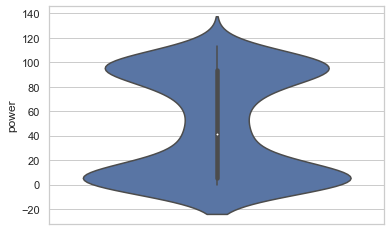

In [34]:
sns.set_theme(style="whitegrid")
sns.violinplot(y=df["power"])

The two variables have multimodal distribution, thus its a mixture of two Gaussian distributions.

In [ ]:
mse = mean_squared_error(y, y_hat)
print(mse)

### SkLearn linear regresssion 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df[['speed']], df['power'], test_size=0.2, random_state=0)


107     3.036
336    91.491
71      2.270
474    96.986
6       5.186
        ...  
323    96.592
192    13.784
117     5.539
47      0.000
172    13.113
Name: power, Length: 400, dtype: float64

The above script splits 80% of the data to training set while 20% of the data to test set. The test_size variable is where we actually specify the proportion of test set.

In [15]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression()

In [38]:
regressor.intercept_

-13.603433993820197

In [39]:
regressor.coef_

array([4.89542079])

### Making Predictions

With the trained  algorithm, it's time to make some predictions. To do so use the test data and see how accurately this algorithm predicts the percentage score. To make pre-dictions on the test data

In [40]:
y_pred = regressor.predict(X_test)

In [41]:
df_diff = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_diff['x_Test'] =X_test
df_diff

,Actual,Predicted,x_Test
90,7.060,10.408605,4.905
254,51.149,48.632051,12.713
283,71.763,57.326318,14.489
445,99.357,96.161691,22.422
461,113.556,100.327694,23.273
...,...,...,...
372,96.058,77.911562,18.694
56,3.578,1.097515,3.003
440,93.931,95.304992,22.247
60,0.000,1.709442,3.128


### Evaluating the Algorithm

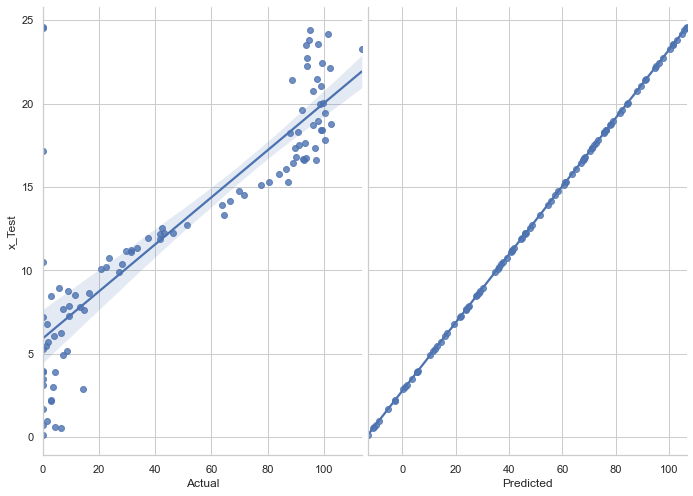

In [42]:
sns.pairplot(df_diff, x_vars=['Actual','Predicted'], y_vars='x_Test', height=7, aspect=0.7, kind='reg')

In [43]:
regressor.score(df[['speed']],df['power'])

0.7289210311482305

### Is that a "good" R-squared value?

Dont know yet. The threshold for a good R-squared value depends widely on the domain. Therefore, it's most useful as a tool for comparing different models

In [44]:
y_hat = regressor.predict(df[['speed']])
mae = mean_absolute_error(df['power'], y_hat)
mae

14.506662948434963

## KMeans Clustering 

K-Means Clustering is an unsupervised machine learning algorithm. K-Means trys to classify data without having first been trained with labeled data. Once the algorithm has been run and the groups are defined, any new data can be easily assigned to the most relevant group [[2]](https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203)

### How it works 
1. Select K (i.e. 2) random points as cluster centers called centroids
2. Assign each data point to the closest cluster by calculating its distance with respect to each centroid
3. Determine the new cluster center by computing the average of the assigned points
4. Repeat steps 2 and 3 until none of the cluster assignments change

### Choosing the right number of clusters (Elbow Method)
A graph of the relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then select the number of clusters where the change in WCSS begins to level off (elbow method). WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.

$$WSS=\sum^m_{i=1}(x_i -c_i)^2$$

In [5]:
# Code from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df) 
    kmeanModel.fit(df)

    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


In [91]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))

1 : 39.81422863329292
2 : 11.520893338343969
3 : 7.76558222341785
4 : 6.171150197174913
5 : 5.419426418915885
6 : 4.931610680781977
7 : 4.25212107156729
8 : 3.7090362306838056
9 : 3.3689615411499787


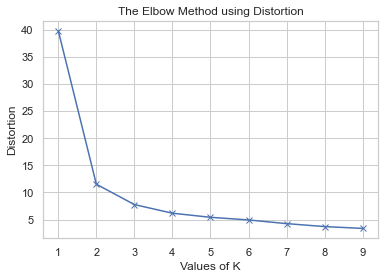

In [92]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

To determine the optimal number of clusters,select the value of k at the elbow ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus concludes that the optimal number of clusters for the data is 3.

Next, categorize the data using the optimum number of clusters (3)  k-means++ ensures that you get don’t fall into the random initialization trap.

In [10]:

kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=0)

In [29]:
y_kmeans = kmeans.fit_predict(df)
df['label'] = y_kmeans

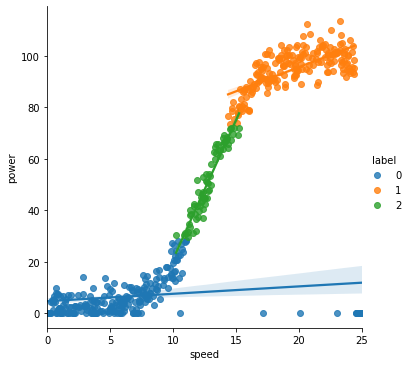

In [30]:
sns.lmplot(x="speed", y="power", hue='label', data=df)

<AxesSubplot:xlabel='speed', ylabel='power'>

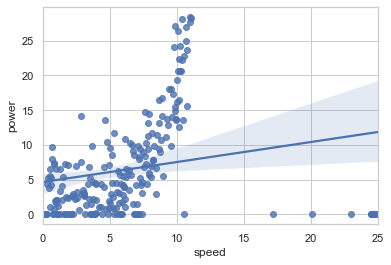

In [96]:
sns.regplot(x="speed", y="power", data=df.loc[y_kmeans == 0])

In [99]:
np.polyfit(df.loc[y_kmeans == 0]['speed'],df.loc[y_kmeans == 0]['power'],1)

array([0.28798421, 4.65969275])

In [24]:
cluster_0df = df.loc[y_kmeans == 0]

X_train0, X_test0, y_train0, y_test0 = train_test_split(cluster_0df[['speed']], cluster_0df['power'], test_size=0.2, random_state=0)
regressor.fit(X_train0, y_train0)

y_hat0 = regressor.predict(cluster_0df[['speed']])
mae0 = mean_absolute_error(cluster_0df['power'], y_hat0)

mae0

5.243273986109941

In [26]:
cluster_0df.tail()

,speed,power
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0
499,25.000,0.0


<AxesSubplot:xlabel='speed', ylabel='power'>

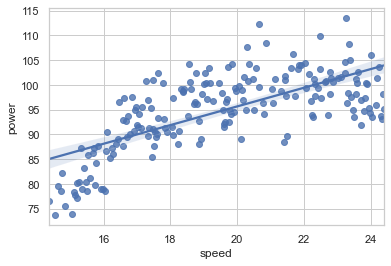

In [97]:
sns.regplot(x="speed", y="power", data=df.loc[y_kmeans == 1])

In [100]:
np.polyfit(df.loc[y_kmeans == 1]['speed'],df.loc[y_kmeans == 1]['power'],1)

array([ 1.88269278, 57.99808409])

In [20]:
cluster_1df = df.loc[y_kmeans == 1]
X_train1, X_test1, y_train1, y_test1 = train_test_split(cluster_1df[['speed']], cluster_1df['power'], test_size=0.2, random_state=0)
regressor.fit(X_train1, y_train1)

y_hat1 = regressor.predict(cluster_1df[['speed']])
mae1 = mean_absolute_error(cluster_1df['power'], y_hat1)

mae1

4.501695063897006

<AxesSubplot:xlabel='speed', ylabel='power'>

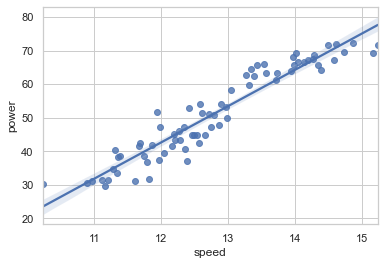

In [98]:

sns.regplot(x="speed", y="power", data=df.loc[y_kmeans == 2])

In [101]:
np.polyfit(df.loc[y_kmeans == 2]['speed'],df.loc[y_kmeans == 2]['power'],1)

array([ 10.81992429, -87.2296644 ])

In [21]:
cluster_2df = df.loc[y_kmeans == 2]
X_train2, X_test2, y_train2, y_test2 = train_test_split(cluster_2df[['speed']], cluster_2df['power'], test_size=0.2, random_state=0)
regressor.fit(X_train2, y_train2)

y_hat2 = regressor.predict(cluster_2df[['speed']])
mae2 = mean_absolute_error(cluster_2df['power'], y_hat2)

mae2

3.3410175212889417

In [32]:
cluster_2df.head()

,speed,power
202,10.235,30.341
214,10.886,30.483
215,10.961,31.153
219,11.111,31.336
220,11.161,29.601


In [ ]:
cluster_2df.tail()

### Tensor Flow Regression

In [65]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)


### Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.
. 

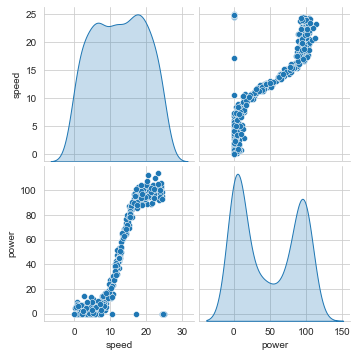

In [66]:
sns.pairplot(train_dataset[['speed', 'power']], diag_kind='kde')

In [67]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,400.0,12.454835,7.196479,0.0,6.21850,12.437,18.56275,25.000
power,400.0,47.597570,41.483785,0.0,5.24925,40.855,93.15350,113.556
label,400.0,0.692500,0.717098,0.0,0.00000,1.000,1.00000,2.000


Split features from labels
Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [68]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('power')
test_labels = test_features.pop('power')

### Normailzation
It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.[[3]](https://www.tensorflow.org/tutorials/keras/regression)

First create the speed Normalization layer:

In [69]:
speed = np.array(train_features['speed'])
speed_normalizer = preprocessing.Normalization(input_shape=[1,])
speed_normalizer.adapt(speed)
speed_model = tf.keras.Sequential([
    speed_normalizer,
    tf.keras.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform")
])
speed_model.add(tf.keras.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
speed_model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 154
Trainable params: 151
Non-trainable params: 3
_________________________________________________________________


Once the model is built, configure the training procedure using the Model.compile() method. The most important arguments to compile are the loss and the optimizer since these define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam).[[3]](https://www.tensorflow.org/tutorials/keras/regression)
Once the training is configured, use Model.fit() to execute the training:

In [70]:
speed_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [71]:
%%time
history = speed_model.fit(
    train_features['speed'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)






Wall time: 9.31 s


In [72]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,5.983214,5.056843,95
96,6.078958,5.340549,96
97,5.771422,4.905964,97
98,6.016509,4.918592,98
99,5.873018,5.482780,99


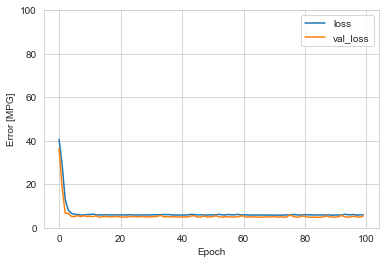

In [73]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

In [74]:
test_results = {}

test_results['speed_model'] = speed_model.evaluate(
    test_features['speed'],
    test_labels, verbose=0)

In [75]:


y = speed_model.predict(test_features['speed'])

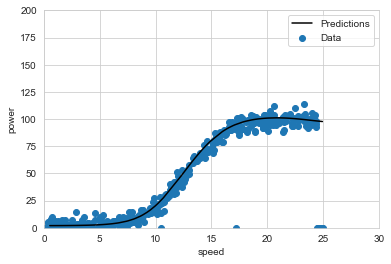

In [76]:
test_results = {}

test_results['speed_model'] = speed_model.evaluate(
    test_features['speed'],
    test_labels, verbose=0)

plt.scatter(train_features['speed'], train_labels, label='Data')
plt.plot(test_features['speed'], y, color='k', label='Predictions')
plt.ylim([0, 200])
plt.xlim([0, 30])
plt.xlabel('speed')
plt.ylabel('power')
plt.legend()

In [77]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
speed_model,6.317786


# Referenses 

1. GeeksForGeeks, Elbow Method for optimal value of k in KMeans,  https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

2. Cory Maklin, Dec 28, 2018, K-means Clustering Python Example, https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

3. TensorFlow Core, Tutorials, Basic regression: Predict fuel efficiency, https://www.tensorflow.org/tutorials/keras/regression

4. Roman Paolucci, Sep 20, 2020, Linear Regression v.s. Neural Networks, https://towardsdatascience.com/linear-regression-v-s-neural-networks-cd03b2938


